In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
import xgboost as xgb
from catboost import CatBoostRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import os

In [6]:
#
#
#
# 5 minutes df
#
#
#

In [7]:
df_5min = pd.read_csv('cleaned_XAUUSD_5_M_01.01.2024-29.03.2025.csv', low_memory=False, sep=',')

In [8]:
df_5min.iloc[5000:5007]

,date,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,...,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week,Y_High_BID,Y_Low_ASK
5000,2024-01-18 08:40:00+00:00,2.010345,2.010895,2.010235,2.010585,0.016843,2.010055,2.010605,2.009945,2.010265,...,0.347336,0.024797,0.29,0.290,0.29,0.32,0,0,2.010605,2.010235
5001,2024-01-18 08:45:00+00:00,2.010575,2.010985,2.010235,2.010255,0.019038,2.010265,2.010698,2.009945,2.009965,...,0.345207,0.028140,0.31,0.287,0.29,0.29,0,0,2.010698,2.010235
5002,2024-01-18 08:50:00+00:00,2.010235,2.010695,2.009935,2.010195,0.013730,2.009945,2.010395,2.009635,2.009845,...,0.361128,0.003140,0.29,0.300,0.30,0.35,0,0,2.010395,2.009935
5003,2024-01-18 08:55:00+00:00,2.010205,2.010435,2.009825,2.009945,0.033064,2.009865,2.010125,2.009525,2.009595,...,0.375043,0.018708,0.34,0.310,0.30,0.35,0,0,2.010125,2.009825
5004,2024-01-18 09:00:00+00:00,2.009925,2.009925,2.008415,2.009185,0.045285,2.009585,2.009585,2.008075,2.008865,...,0.353645,0.014891,0.34,0.340,0.34,0.32,0,0,2.009585,2.008415
5005,2024-01-18 09:05:00+00:00,2.009185,2.009705,2.009055,2.009175,0.044521,2.008855,2.009355,2.008725,2.008865,...,0.378051,0.023432,0.33,0.350,0.33,0.31,0,0,2.009355,2.009055
5006,2024-01-18 09:10:00+00:00,2.009215,2.010065,2.008615,2.009665,0.023355,2.008905,2.009775,2.008325,2.009325,...,0.335157,0.043919,0.31,0.290,0.29,0.34,0,0,2.009775,2.008615


In [9]:
df_5min_informer = pd.read_csv('./cleaned_XAUUSD_5_M_01.01.2024-29.03.2025_for_informer.csv')

In [10]:
df_5min_informer.head()

,date,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
0,2024-01-01 00:00:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
1,2024-01-01 00:05:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
2,2024-01-01 00:10:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
3,2024-01-01 00:15:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
4,2024-01-01 00:20:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0


In [7]:
'''
We will predict the Highest and Lowest prices for the next 5 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 5 minutes up (1 row)

Then you need to delete the last row since there are no prices for the next 5 minutes.
Therefore, we will create an array of answers "data_ay" with the 
Highest and Lowest prices shifted sequentially to 1 row up.
'''

'\nWe will predict the Highest and Lowest prices for the next 5 minutes.\n\nTo do this in the data output (vector of answers), we shift prices sequentially to 5 minutes up (1 row)\n\nThen you need to delete the last row since there are no prices for the next 5 minutes.\nTherefore, we will create an array of answers "data_ay" with the \nHighest and Lowest prices shifted sequentially to 1 row up.\n'

In [8]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [9]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [10]:
print(outputs_data.tail(2), '\n')
outputs_data = outputs_data.shift(-1)
print(outputs_data.tail(2))

        Y_High_BID  Y_Low_ASK
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118094    3.083898   3.086702
118095         NaN        NaN


In [11]:
outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118093,3.083898,3.086702
118094,3.083898,3.086702


In [12]:
inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118093,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118094,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [13]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118095, 18) 
outputs Numpy array size: (118095, 2)


In [14]:
# We need a three-dimensional data tensor: [(nb of rows - N), N, 20] and
# two-dimensional array of answers [(nb of rows - N), 2] with the High and Low prices DURING the next 5 minutes
# where N=25 (~2 hours '125 minutes') is the number of minutes for analysis at each step; those are looking backwards

In [15]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118070 25 18


In [16]:
# create inputs zeros 3D tensors with 'float32'
data_in = np.zeros( (L, N, t), dtype= 'float32' )

# create a 2D zeros vector of answers
data_out = np.zeros((L, 2), dtype= 'float32')

In [17]:
# fill the inputs 3D tensor (data_in)
# and the array of answers data_out

for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 10 minutes future price
    data_out[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 10 minutes future price

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118070/118070 [00:00<00:00, 244513.48it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [18]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118070, 25, 18) 
outputs 2D vector size: (118070, 2)


In [24]:
def walk_forward_split(X, y, train_size, test_size):
    X_train_blocks, X_test_blocks = [], []
    y_train_blocks, y_test_blocks = [], []

    start = 0
    while (start + train_size + test_size) <= len(X):
        end_train = start + train_size
        end_test = end_train + test_size

        X_train_blocks.append(X[start:end_train])
        X_test_blocks.append(X[end_train:end_test])
        y_train_blocks.append(y[start:end_train])
        y_test_blocks.append(y[end_train:end_test])

        start += train_size
    '''
    # Add remaining samples to the LAST BLOCK instead of creating a new one
    remaining = len(X) - start
    if remaining > 0:
        # Append to last train/test blocks
        start = start-train_size
        last_end_train = len(X)-test_size

        X_train_blocks[-1] = X[start:last_end_train]
        y_train_blocks[-1] = y[start:last_end_train]

        X_test_blocks[-1] = X[last_end_train:len(X)]
        y_test_blocks[-1] = y[last_end_train:len(X)]
    '''
    return X_train_blocks, X_test_blocks, y_train_blocks, y_test_blocks

In [25]:
def walk_forward_split_for_informer(df, output_dir, train_size, test_size):
    """
    df: full DataFrame
    output_dir: folder direction to save the blocks in
    train_size: number of samples in training set
    test_size: number of samples in test set
    """
    os.makedirs(output_dir, exist_ok=True)
    block_counter = 0
    start = 0
    
    while (start + train_size + test_size) <= len(df):
        end_train = start + train_size
        end_test = end_train + test_size

        print(f"Start: {start} | End Train: {end_train} | End Test: {end_test}")
        
        sub_df = df.iloc[start:end_test]
        output_path = os.path.join(output_dir, f"walk_forward_block_{block_counter}.csv")
        sub_df.to_csv(output_path, index=False)
        print(f"Block {block_counter} | Rows: {sub_df.shape[0]} | Columns: {sub_df.shape[1]} | Path: {output_path}")
        
        start += train_size
        block_counter += 1
        
    return block_counter

In [27]:
train_size, test_size = 16500, 2500

In [22]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [23]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [31]:
number_of_blocks_for_informer = walk_forward_split_for_informer(df_5min_informer, './walk_forward_data_split_informer', train_size, test_size)

Start: 0 | End Train: 16500 | End Test: 19000
Block 0 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_0.csv
Start: 16500 | End Train: 33000 | End Test: 35500
Block 1 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_1.csv
Start: 33000 | End Train: 49500 | End Test: 52000
Block 2 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_2.csv
Start: 49500 | End Train: 66000 | End Test: 68500
Block 3 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_3.csv
Start: 66000 | End Train: 82500 | End Test: 85000
Block 4 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_4.csv
Start: 82500 | End Train: 99000 | End Test: 101500
Block 5 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_5.csv
Start: 99000 | End Train: 115500 | End Test: 118000
Block 6 | Rows: 19000 | Col

In [46]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer}")

Number of walk-forward blocks for training Informer: 7


In [26]:
#
# LSTM-XGBOOST model
#

In [27]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
results_next_5min_LSTM_XGB = []

In [29]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_5min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2708 - val_loss: 2.2377e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.2027e-04 - val_loss: 1.4122e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.1261e-05 - val_loss: 1.2223e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.1993e-05 - val_loss: 9.4520e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.9493e-05 - val_loss: 8.9021e-05
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.4005e-05 - val_loss: 1.1028e-04
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.6622e-05 - val_loss: 1.1674e-04
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.4719e-05 - val_loss: 1.3249e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.2924e-05 - val_loss: 1.2347e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.5861e-05 - val_loss: 8.8094e-05
Epoch 11/100
413/4

In [30]:
metrics_next_5min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_5min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_5min_LSTM_XGB]) for metric in metrics_next_5min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_5min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0085
Average rmse_low_ask: 0.0088
Average mae_high_bid: 0.0050
Average mae_low_ask: 0.0052
Average r2_high_bid: 0.8425
Average r2_low_ask: 0.8315


In [31]:
#
# LSTM-CATBOOST model
#

In [32]:
results_next_5min_LSTM_CAT = []

In [33]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])
LSTM_model_for_cat.summary()
LSTM_model_for_cat.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_5min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3643 - val_loss: 1.8895e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.5223e-04 - val_loss: 4.3808e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.4586e-05 - val_loss: 5.3354e-05
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.3160e-05 - val_loss: 2.6887e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.9268e-05 - val_loss: 4.4973e-05
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.1924e-05 - val_loss: 2.3459e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.9853e-05 - val_loss: 7.8702e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.0927e-05 - val_loss: 1.2666e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.9526e-05 - val_loss: 1.9776e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.5152e-05 - val_loss: 3.8715e-05
Epoch 11/100
413/413

In [35]:
metrics_next_5min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_5min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_5min_LSTM_CAT]) for metric in metrics_next_5min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_5min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0095
Average rmse_low_ask: 0.0098
Average mae_high_bid: 0.0059
Average mae_low_ask: 0.0061
Average r2_high_bid: 0.8028
Average r2_low_ask: 0.7939


In [36]:
#
# Informer model
#

In [37]:
#!git clone https://github.com/zhouhaoyi/Informer2020.git

In [38]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [39]:
Informer_model = Exp_Informer

In [40]:
results_next_5min_Informer = []

In [41]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_5min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl1_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13012
val 1900
test 3800
	iters: 100, epoch: 1 | loss: 0.2852382
	speed: 3.0526s/iter; left time: 12091.4319s
	iters: 200, epoch: 1 | loss: 0.0555219
	speed: 3.0113s/iter; left time: 11626.5592s
	iters: 300, epoch: 1 | loss: 0.3174791
	speed: 3.0581s/iter; left time: 11501.5332s
	iters: 400, epoch: 1 | loss: 0.1076475
	speed: 3.0169s/iter; left time: 11044.7108s
Epoch: 1 cost time: 1228.2860081195831
Epoch: 1, Steps: 406 | Train Loss: 0.3445405 Vali Loss: 0.3461871 Test Loss: 1.0341607
Validation loss decreased (inf --> 0.346187).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1090561
	speed: 5.2354s/iter; left time: 18611.9235s
	iters: 200, epoch: 2 | loss: 0.0929468
	speed: 3.0568s/iter; left time: 10561.1233s
	iters: 300, epoch: 2 | loss: 0.1050194
	speed: 3.0607s/iter; left time: 10268.6496s
	iters: 400, e

In [42]:
metrics_next_5min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_5min_Informer = {metric: np.mean([r[metric] for r in results_next_5min_Informer]) for metric in metrics_next_5min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_5min_Informer.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.2948
Average rmse_low_ask: 0.2968
Average mae_high_bid: 0.1886
Average mae_low_ask: 0.1898
Average r2_high_bid: 0.7314
Average r2_low_ask: 0.7352


In [43]:
#
# Visualisation
#

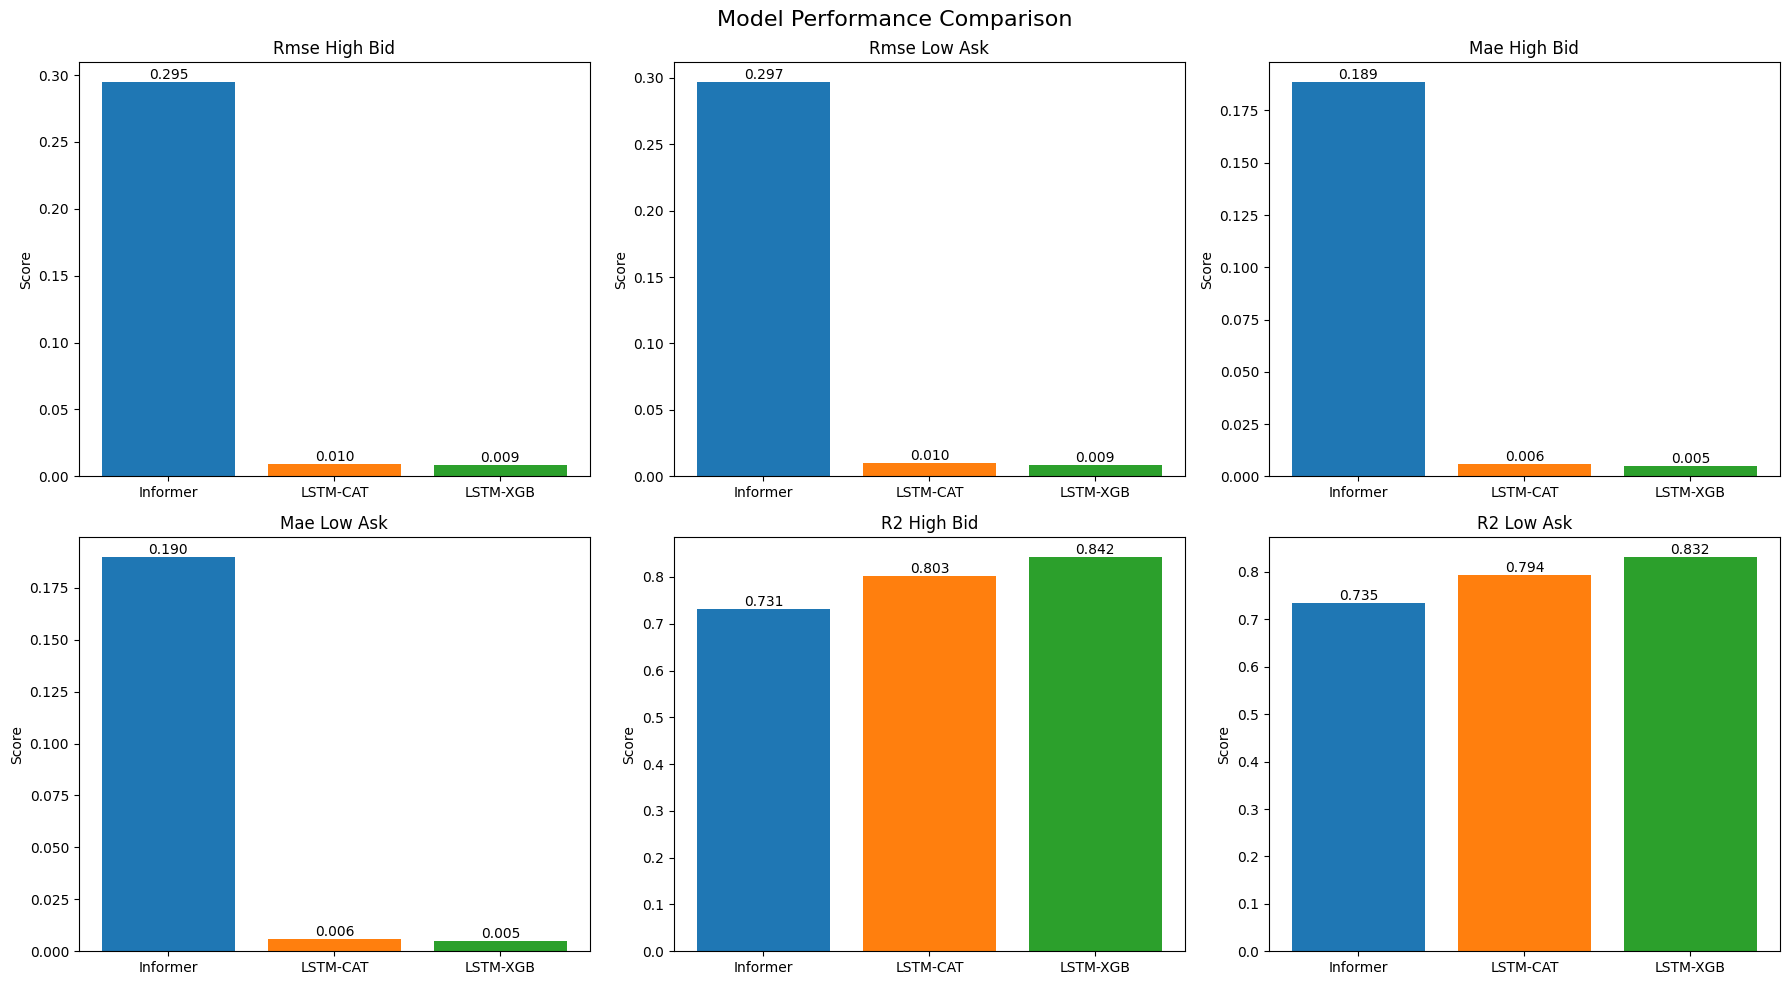

In [44]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_5min_Informer,
    'LSTM-CAT': avg_results_next_5min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_5min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [5]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_5min_Informer)+1)

# Create figure
plt.figure(figsize=(15, 8))

# Plot R2 evolution
plt.subplot(2, 1, 1)
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot MAE evolution
plt.subplot(2, 1, 2)
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'results_next_5min_Informer' is not defined

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 15 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 15 minutes up (3 rows)

Then you need to delete the last 3 rows since there are no prices for the next 15 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 3 rows up.
'''

In [13]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [14]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [15]:
print(outputs_data.tail(4), '\n')
outputs_data = outputs_data.shift(-3)
print(outputs_data.tail(4))

        Y_High_BID  Y_Low_ASK
118092    3.083898   3.086702
118093    3.083898   3.086702
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118092    3.083898   3.086702
118093         NaN        NaN
118094         NaN        NaN
118095         NaN        NaN


In [16]:
#outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data = outputs_data.iloc[:-3]
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118091,3.083898,3.086702
118092,3.083898,3.086702


In [17]:
#inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data = inputs_data.iloc[:-3]
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118091,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118092,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [18]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118093, 18) 
outputs Numpy array size: (118093, 2)


In [19]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118068 25 18


In [20]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [21]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118068/118068 [00:00<00:00, 147214.10it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [22]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118068, 25, 18) 
outputs 2D vector size: (118068, 2)


In [26]:
train_size, test_size = 16500, 2500

In [27]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [28]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [29]:
#
# LSTM-XGBOOST model
#

In [30]:
results_next_15min_LSTM_XGB = []

In [31]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.1784 - val_loss: 5.1323e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 1.6233e-04 - val_loss: 1.3183e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 9.4853e-05 - val_loss: 8.5824e-05
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.6760e-05 - val_loss: 5.5840e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 3.3450e-05 - val_loss: 7.6394e-05
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.7678e-05 - val_loss: 6.5644e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 2.0812e-05 - val_loss: 4.9043e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 1.7534e-05 - val_loss: 9.5082e-05
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 1.5059e-05 - val_loss: 6.7884e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9669e-05 - val_loss: 4.3251e-05
Epoch 11/1

In [33]:
metrics_next_15min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_XGB]) for metric in metrics_next_15min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0097
Average rmse_low_ask: 0.0099
Average mae_high_bid: 0.0058
Average mae_low_ask: 0.0061
Average r2_high_bid: 0.8028
Average r2_low_ask: 0.7968


In [34]:
#
# LSTM-CATBOOST model
#

In [35]:
results_next_15min_LSTM_CAT = []

In [36]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0606 - val_loss: 4.0018e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7.5655e-05 - val_loss: 2.1449e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.2159e-05 - val_loss: 1.7286e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.9054e-05 - val_loss: 1.7353e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.8589e-05 - val_loss: 1.5147e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.8767e-05 - val_loss: 1.3148e-04
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.1672e-05 - val_loss: 1.1949e-04
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.3539e-05 - val_loss: 1.0957e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.3001e-05 - val_loss: 2.2164e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.2317e-05 - val_loss: 9.4201e-05
Epoch 11/100
413/41

In [38]:
metrics_next_15min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_CAT]) for metric in metrics_next_15min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0095
Average rmse_low_ask: 0.0097
Average mae_high_bid: 0.0057
Average mae_low_ask: 0.0059
Average r2_high_bid: 0.8142
Average r2_low_ask: 0.8088


In [39]:
#
# Informer model
#

In [40]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 3 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [41]:
Informer_model = Exp_Informer

In [42]:
results_next_15min_Informer = []

In [47]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_15min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl3_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13010
val 1898
test 3798
	iters: 100, epoch: 1 | loss: 0.1940719
	speed: 3.9871s/iter; left time: 15793.0280s
	iters: 200, epoch: 1 | loss: 0.4989661
	speed: 3.3745s/iter; left time: 13028.9761s
	iters: 300, epoch: 1 | loss: 0.3594683
	speed: 3.3995s/iter; left time: 12785.4072s
	iters: 400, epoch: 1 | loss: 0.2475406
	speed: 3.3808s/iter; left time: 12377.0272s
Epoch: 1 cost time: 1431.8389024734497
Epoch: 1, Steps: 406 | Train Loss: 0.3506591 Vali Loss: 0.3666972 Test Loss: 1.0419750
Validation loss decreased (inf --> 0.366697).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1733075
	speed: 5.6528s/iter; left time: 20095.6969s
	iters: 200, epoch: 2 | loss: 0.1485413
	speed: 3.3305s/iter; left time: 11506.9570s
	iters: 300, epoch: 2 | loss: 0.2185349
	speed: 3.2847s/iter; left time: 11020.0219s
	iters: 400, e

In [48]:
metrics_next_15min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_Informer = {metric: np.mean([r[metric] for r in results_next_15min_Informer]) for metric in metrics_next_15min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_Informer.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.3196
Average rmse_low_ask: 0.3220
Average mae_high_bid: 0.2028
Average mae_low_ask: 0.2033
Average r2_high_bid: 0.5739
Average r2_low_ask: 0.5598


In [ ]:
#
# Visualisation
#

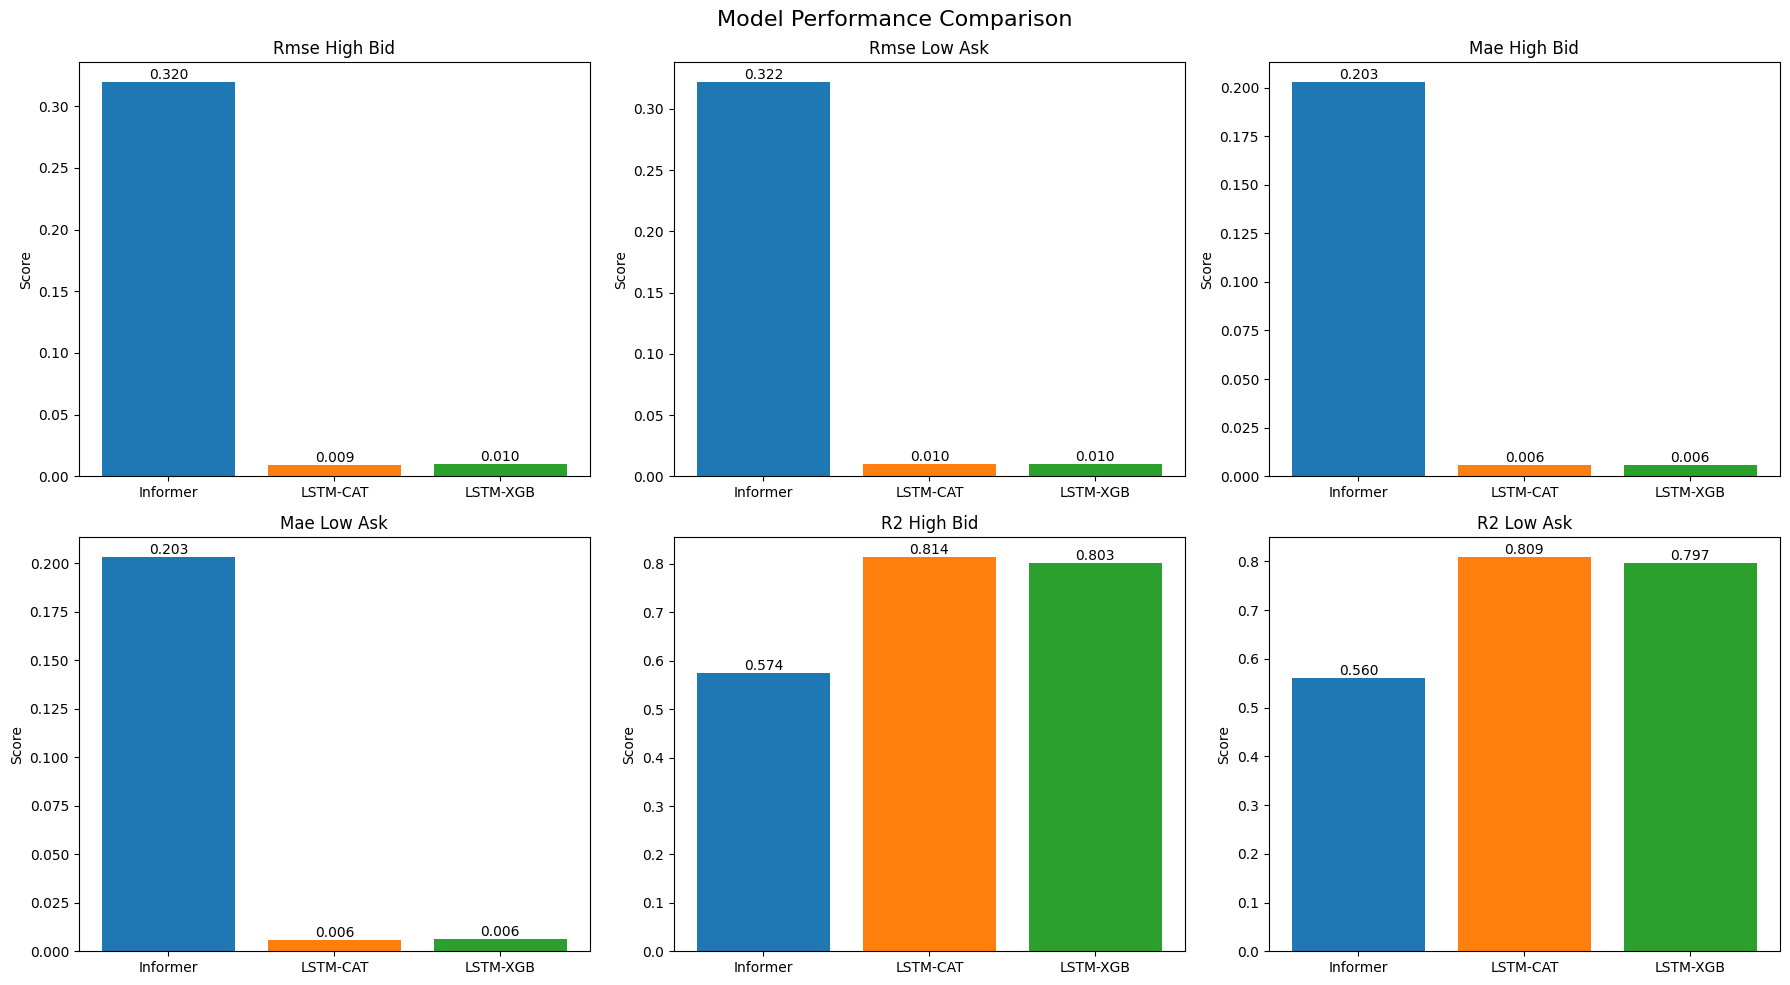

In [49]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_15min_Informer,
    'LSTM-CAT': avg_results_next_15min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_15min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

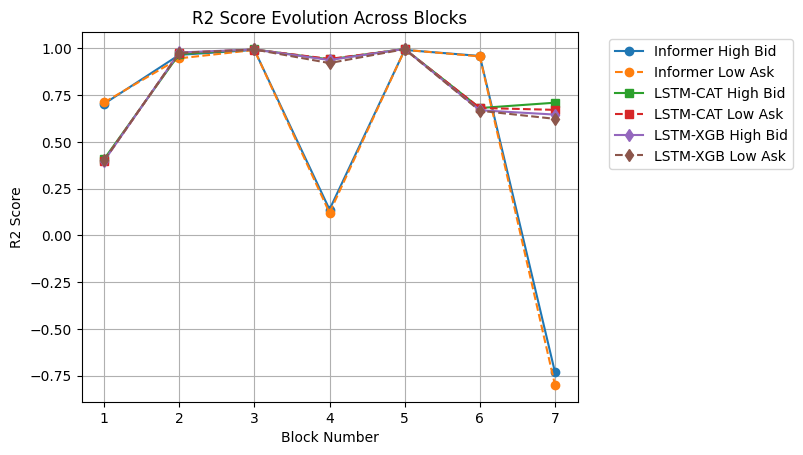

In [58]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer)+1)

# Plot R2 evolution

plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

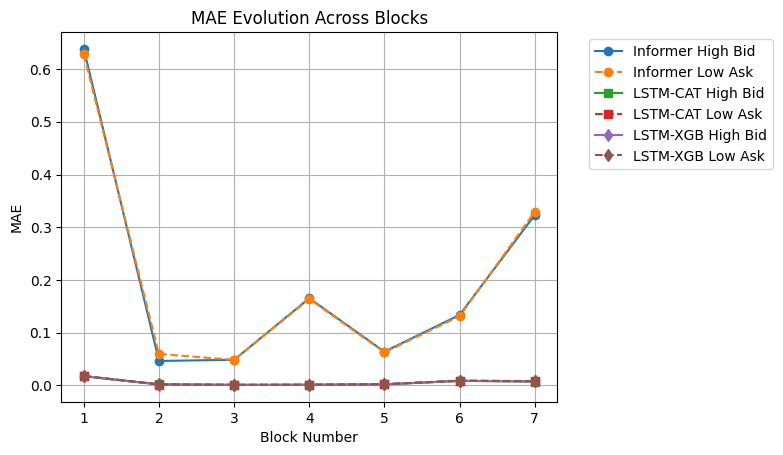

In [57]:
# Plot MAE evolution

plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 30 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 30 minutes up (6 rows)

Then you need to delete the last 6 rows since there are no prices for the next 30 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 6 rows up.
'''

In [59]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [60]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [61]:
print(outputs_data.tail(7), '\n')
outputs_data = outputs_data.shift(-6)
print(outputs_data.tail(7))

        Y_High_BID  Y_Low_ASK
118089    3.083898   3.086702
118090    3.083898   3.086702
118091    3.083898   3.086702
118092    3.083898   3.086702
118093    3.083898   3.086702
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118089    3.083898   3.086702
118090         NaN        NaN
118091         NaN        NaN
118092         NaN        NaN
118093         NaN        NaN
118094         NaN        NaN
118095         NaN        NaN


In [62]:
outputs_data = outputs_data.iloc[:-6]
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118088,3.083898,3.086702
118089,3.083898,3.086702


In [63]:
inputs_data = inputs_data.iloc[:-6]
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118088,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118089,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [64]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118090, 18) 
outputs Numpy array size: (118090, 2)


In [65]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118065 25 18


In [66]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [67]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118065/118065 [00:00<00:00, 185900.94it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [68]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118065, 25, 18) 
outputs 2D vector size: (118065, 2)


In [69]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [70]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [71]:
#
# LSTM-XGBOOST model
#

In [72]:
results_next_30min_LSTM_XGB = []

In [73]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1056 - val_loss: 1.5351e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.2121e-05 - val_loss: 1.1924e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.8353e-05 - val_loss: 1.0743e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.2090e-05 - val_loss: 8.5668e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.9591e-05 - val_loss: 7.8641e-05
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.6950e-05 - val_loss: 7.3548e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.2846e-05 - val_loss: 6.9529e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.9767e-05 - val_loss: 8.8470e-05
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.4143e-05 - val_loss: 6.8317e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.1358e-05 - val_loss: 5.7611e-05
Epoch 11/100
413/41

In [75]:
metrics_next_30min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_XGB]) for metric in metrics_next_30min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0104
Average rmse_low_ask: 0.0113
Average mae_high_bid: 0.0064
Average mae_low_ask: 0.0071
Average r2_high_bid: 0.7793
Average r2_low_ask: 0.7354


In [76]:
#
# LSTM-CATBOOST model
#

In [77]:
results_next_30min_LSTM_CAT = []

In [78]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1203 - val_loss: 6.1748e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.5524e-05 - val_loss: 2.2546e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.9536e-05 - val_loss: 1.3609e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.4690e-05 - val_loss: 1.0948e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.6050e-05 - val_loss: 1.1536e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.4105e-05 - val_loss: 1.0032e-04
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.1545e-05 - val_loss: 9.8415e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.8575e-05 - val_loss: 1.0492e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.8283e-05 - val_loss: 9.5476e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.9582e-05 - val_loss: 8.5254e-05
Epoch 11/100
4

In [80]:
metrics_next_30min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_CAT]) for metric in metrics_next_30min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0101
Average rmse_low_ask: 0.0105
Average mae_high_bid: 0.0062
Average mae_low_ask: 0.0066
Average r2_high_bid: 0.7937
Average r2_low_ask: 0.7809


In [81]:
#
# Informer model
#

In [82]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 6 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [83]:
Informer_model = Exp_Informer

In [84]:
results_next_30min_Informer = []

In [85]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_30min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl6_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13007
val 1895
test 3795
	iters: 100, epoch: 1 | loss: 0.2952909
	speed: 3.2882s/iter; left time: 13024.5285s
	iters: 200, epoch: 1 | loss: 0.2785594
	speed: 3.2824s/iter; left time: 12673.3908s
	iters: 300, epoch: 1 | loss: 0.1563375
	speed: 3.3399s/iter; left time: 12561.4870s
	iters: 400, epoch: 1 | loss: 0.1728825
	speed: 3.2970s/iter; left time: 12070.1712s
Epoch: 1 cost time: 1341.559654712677
Epoch: 1, Steps: 406 | Train Loss: 0.3567626 Vali Loss: 0.3788217 Test Loss: 1.1077231
Validation loss decreased (inf --> 0.378822).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1224565
	speed: 5.6058s/iter; left time: 19928.6886s
	iters: 200, epoch: 2 | loss: 0.8799350
	speed: 3.2697s/iter; left time: 11296.8133s
	iters: 300, epoch: 2 | loss: 0.1875768
	speed: 3.2916s/iter; left time: 11043.2978s
	iters: 400, ep

In [86]:
metrics_next_30min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_Informer = {metric: np.mean([r[metric] for r in results_next_30min_Informer]) for metric in metrics_next_30min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_Informer.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.3421
Average rmse_low_ask: 0.3346
Average mae_high_bid: 0.2255
Average mae_low_ask: 0.2162
Average r2_high_bid: 0.5838
Average r2_low_ask: 0.6190


In [ ]:
#
# Visualisation
#

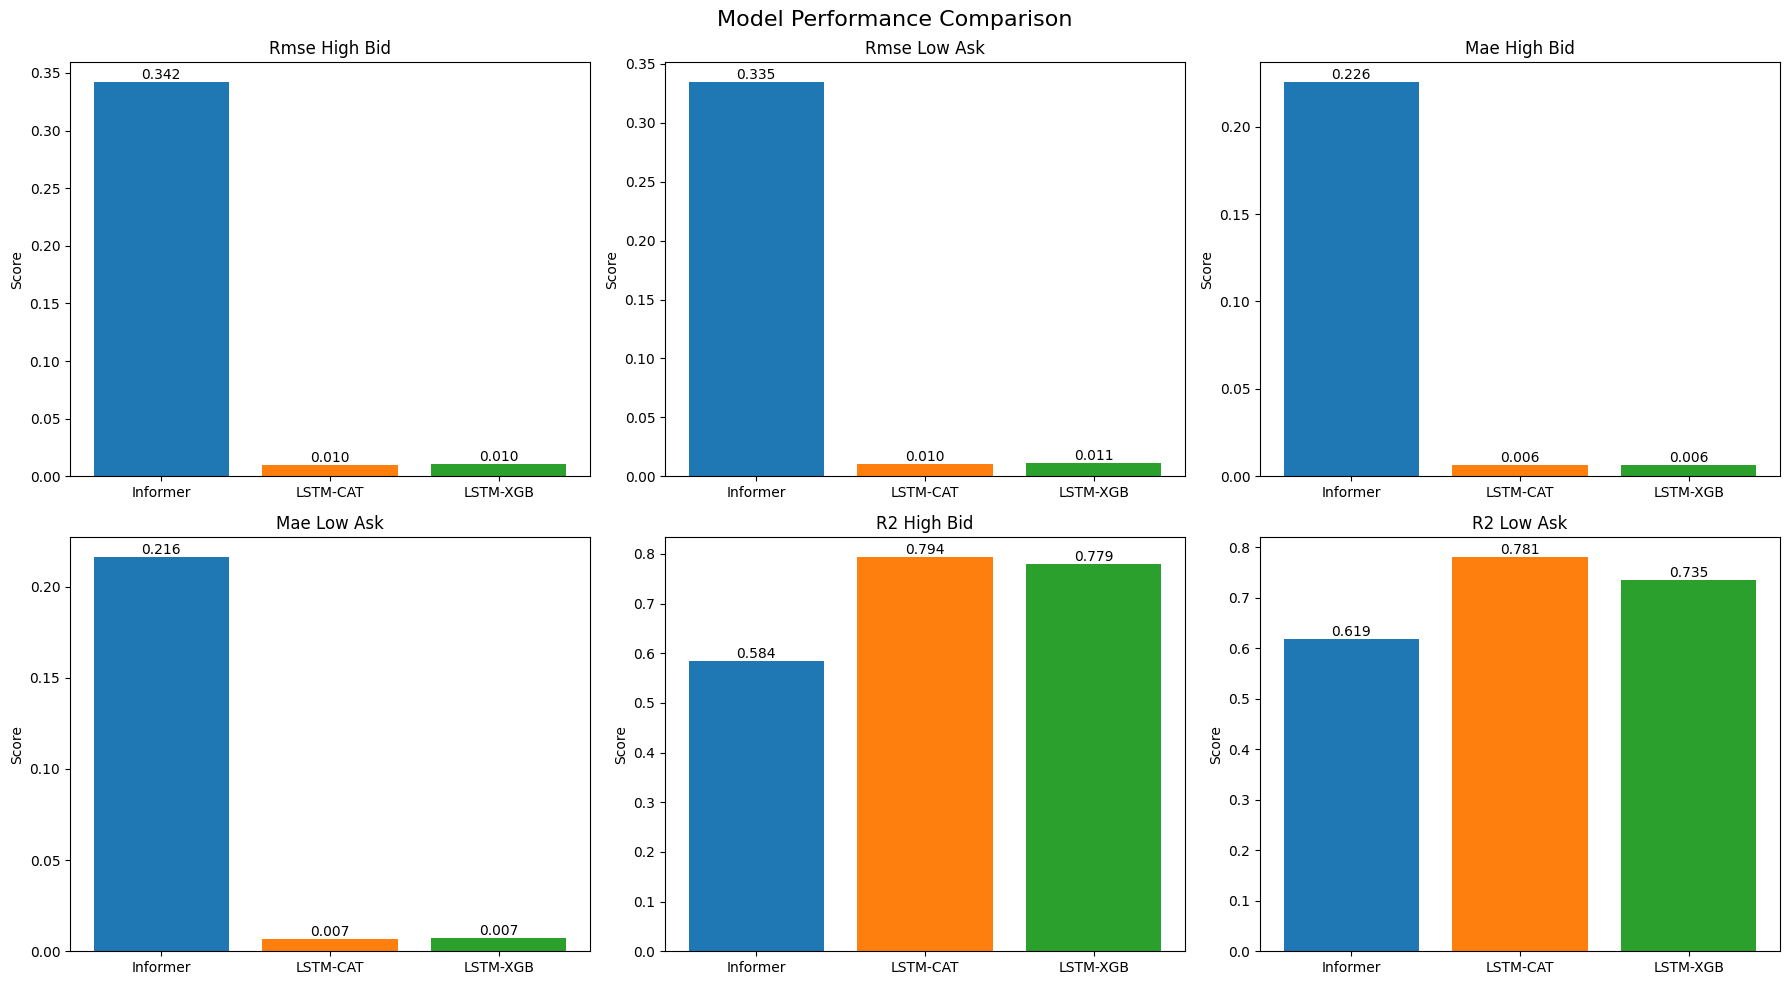

In [87]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_30min_Informer,
    'LSTM-CAT': avg_results_next_30min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_30min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

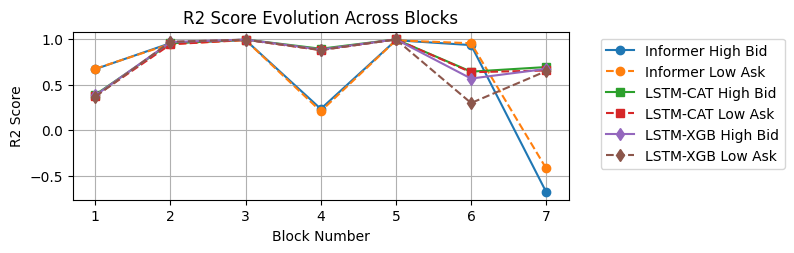

In [88]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer)+1)

# Plot R2 evolution
plt.subplot(2, 1, 1)
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

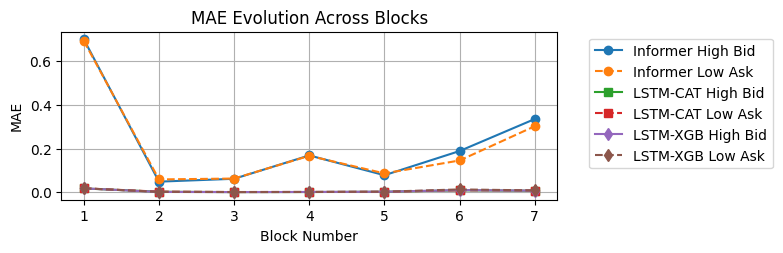

In [89]:
# Plot MAE evolution
plt.subplot(2, 1, 2)
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [11]:
'''
We will predict the Highest and Lowest prices for the next 60 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (12 rows)

Then you need to delete the last 12 rows since there are no prices for the next 60 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 12 rows up.
'''

'\nWe will predict the Highest and Lowest prices for the next 60 minutes.\n\nTo do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (12 rows)\n\nThen you need to delete the last 12 rows since there are no prices for the next 60 minutes.\n\nTherefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 12 rows up.\n'

In [12]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [13]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [14]:
print(outputs_data.tail(12), '\n')
outputs_data = outputs_data.shift(-12)
print(outputs_data.tail(12))

        Y_High_BID  Y_Low_ASK
118084    3.083898   3.086702
118085    3.083898   3.086702
118086    3.083898   3.086702
118087    3.083898   3.086702
118088    3.083898   3.086702
118089    3.083898   3.086702
118090    3.083898   3.086702
118091    3.083898   3.086702
118092    3.083898   3.086702
118093    3.083898   3.086702
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118084         NaN        NaN
118085         NaN        NaN
118086         NaN        NaN
118087         NaN        NaN
118088         NaN        NaN
118089         NaN        NaN
118090         NaN        NaN
118091         NaN        NaN
118092         NaN        NaN
118093         NaN        NaN
118094         NaN        NaN
118095         NaN        NaN


In [15]:
outputs_data = outputs_data.iloc[:-12]
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118082,3.083898,3.086702
118083,3.083898,3.086702


In [16]:
inputs_data = inputs_data.iloc[:-12]
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118082,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118083,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [17]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118084, 18) 
outputs Numpy array size: (118084, 2)


In [18]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118059 25 18


In [19]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [20]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118059/118059 [00:00<00:00, 212133.48it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [21]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118059, 25, 18) 
outputs 2D vector size: (118059, 2)


In [28]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [29]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [32]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer}")

Number of walk-forward blocks for training Informer: 7


In [33]:
#
# LSTM-XGBOOST model
#

In [34]:
results_next_60min_LSTM_XGB = []

In [35]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1188 - val_loss: 2.5678e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.8116e-04 - val_loss: 2.0351e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.4384e-04 - val_loss: 1.1255e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.0695e-04 - val_loss: 1.0017e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.9737e-05 - val_loss: 2.6340e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.8852e-05 - val_loss: 9.7539e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.6171e-05 - val_loss: 1.2769e-04
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.4139e-05 - val_loss: 1.9706e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.3868e-05 - val_loss: 3.1810e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.7205e-05 - val_loss: 4.8108e-04
Epoch 11/100
413/4

In [37]:
metrics_next_60min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_XGB]) for metric in metrics_next_60min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0122
Average rmse_low_ask: 0.0125
Average mae_high_bid: 0.0079
Average mae_low_ask: 0.0080
Average r2_high_bid: 0.7100
Average r2_low_ask: 0.6938


In [38]:
#
# LSTM-CATBOOST model
#

In [39]:
results_next_60min_LSTM_CAT = []

In [40]:
'''LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(N, data_in.shape[2])),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(32),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2)
])'''
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2239 - val_loss: 7.9866e-05
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.2773e-05 - val_loss: 1.0386e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.1105e-05 - val_loss: 1.0303e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.2810e-05 - val_loss: 9.8836e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.0858e-05 - val_loss: 1.2327e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.7661e-05 - val_loss: 6.2304e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.0588e-05 - val_loss: 8.2087e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.1635e-05 - val_loss: 7.9514e-05
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.2459e-05 - val_loss: 6.8772e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.9050e-05 - val_loss: 8.3836e-05
Epoch 11/100
413/41

In [42]:
metrics_next_60min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_CAT]) for metric in metrics_next_60min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0120
Average rmse_low_ask: 0.0122
Average mae_high_bid: 0.0079
Average mae_low_ask: 0.0080
Average r2_high_bid: 0.7157
Average r2_low_ask: 0.7067


In [43]:
#
# Informer model
#

In [44]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 12 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [45]:
Informer_model = Exp_Informer

In [46]:
results_next_60min_Informer = []

In [ ]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_60min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl12_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13001
val 1889
test 3789
	iters: 100, epoch: 1 | loss: 0.2484927
	speed: 3.3150s/iter; left time: 13130.5539s
	iters: 200, epoch: 1 | loss: 0.2470320
	speed: 3.2597s/iter; left time: 12585.8583s
	iters: 300, epoch: 1 | loss: 0.2072832
	speed: 3.2509s/iter; left time: 12226.5975s
	iters: 400, epoch: 1 | loss: 0.6216202
	speed: 3.2446s/iter; left time: 11878.3744s
Epoch: 1 cost time: 1321.5200595855713
Epoch: 1, Steps: 406 | Train Loss: 0.3646227 Vali Loss: 0.3924667 Test Loss: 1.0861746
Validation loss decreased (inf --> 0.392467).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.2383357
	speed: 5.5158s/iter; left time: 19608.5842s
	iters: 200, epoch: 2 | loss: 0.5557006
	speed: 3.2506s/iter; left time: 11230.8962s
	iters: 300, epoch: 2 | loss: 0.3447479
	speed: 3.2754s/iter; left time: 10988.8909s
	iters: 400, 

In [ ]:
metrics_next_60min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_Informer = {metric: np.mean([r[metric] for r in results_next_60min_Informer]) for metric in metrics_next_60min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_Informer.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Visualisation
#

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_60min_Informer,
    'LSTM-CAT': avg_results_next_60min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_60min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer)+1)

# Plot R2 evolution
plt.subplot(2, 1, 1)
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
# Plot MAE evolution
plt.subplot(2, 1, 2)
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
'''
#
#
# Results Visualisation Across Timeframes
#
#
'''

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collecting all metrics into one DataFrame
forecast_horizons = ['5min', '15min', '30min', '60min']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']

all_results = {
    '5min': avg_results_next_5min_LSTM_XGB,
    '15min': avg_results_next_15min_LSTM_XGB,
    '30min': avg_results_next_30min_LSTM_XGB,
    '60min': avg_results_next_60min_LSTM_XGB
}

df_plot_LSTM_XGB = pd.DataFrame(all_results).T  # Transpose for plotting

# Plotting each metric as a separate bar chart
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=df_plot_LSTM_XGB.index, y=df_plot_LSTM_XGB[metric], palette="viridis")
    plt.title(f'{metric.upper()} Across LSTM_XGB Prediction Horizons')
    plt.xlabel('Forecast Horizon')
    plt.ylabel(metric.upper())
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [ ]:
# Collecting all metrics into one DataFrame
forecast_horizons = ['5min', '15min', '30min', '60min']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']

all_results = {
    '5min': avg_results_next_5min_LSTM_CAT,
    '15min': avg_results_next_15min_LSTM_CAT,
    '30min': avg_results_next_30min_LSTM_CAT,
    '60min': avg_results_next_60min_LSTM_CAT
}

df_plot_LSTM_CAT = pd.DataFrame(all_results).T  # Transpose for plotting

# Plotting each metric as a separate bar chart
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=df_plot_LSTM_CAT.index, y=df_plot_LSTM_CAT[metric], palette="viridis")
    plt.title(f'{metric.upper()} Across LSTM_CAT Prediction Horizons')
    plt.xlabel('Forecast Horizon')
    plt.ylabel(metric.upper())
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [ ]:
# Collecting all metrics into one DataFrame
forecast_horizons = ['5min', '15min', '30min', '60min']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']

all_results = {
    '5min': avg_results_next_5min_Informer,
    '15min': avg_results_next_15min_Informer,
    '30min': avg_results_next_30min_Informer,
    '60min': avg_results_next_60min_Informer
}

df_plot_Informer = pd.DataFrame(all_results).T  # Transpose for plotting

# Plotting each metric as a separate bar chart
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=df_plot_Informer.index, y=df_plot_Informer[metric], palette="viridis")
    plt.title(f'{metric.upper()} Across Informer Prediction Horizons')
    plt.xlabel('Forecast Horizon')
    plt.ylabel(metric.upper())
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['rmse_high_bid', 'rmse_low_ask']:
    plt.plot(df_plot_LSTM_XGB.index, df_plot_LSTM_XGB[metric], marker='o', label=metric)

plt.title('RMSE Across LSTM_XGB Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['rmse_high_bid', 'rmse_low_ask']:
    plt.plot(df_plot_LSTM_CAT.index, df_plot_LSTM_CAT[metric], marker='o', label=metric)

plt.title('RMSE Across LSTM_CAT Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['rmse_high_bid', 'rmse_low_ask']:
    plt.plot(df_plot_Informer.index, df_plot_Informer[metric], marker='o', label=metric)

plt.title('RMSE Across Informer Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['mae_high_bid', 'mae_low_ask']:
    plt.plot(df_plot_LSTM_XGB.index, df_plot_LSTM_XGB[metric], marker='o', label=metric)

plt.title('MAE Across LSTM_XGB Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['mae_high_bid', 'mae_low_ask']:
    plt.plot(df_plot_LSTM_CAT.index, df_plot_LSTM_CAT[metric], marker='o', label=metric)

plt.title('MAE Across LSTM_CAT Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['mae_high_bid', 'mae_low_ask']:
    plt.plot(df_plot_Informer.index, df_plot_Informer[metric], marker='o', label=metric)

plt.title('MAE Across Informer Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['r2_high_bid', 'r2_low_ask']:
    plt.plot(df_plot_LSTM_XGB.index, df_plot_LSTM_XGB[metric], marker='o', label=metric)

plt.title('R2 Across LSTM_XGB Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['r2_high_bid', 'r2_low_ask']:
    plt.plot(df_plot_LSTM_CAT.index, df_plot_LSTM_CAT[metric], marker='o', label=metric)

plt.title('R2 Across LSTM_CAT Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in ['r2_high_bid', 'r2_low_ask']:
    plt.plot(df_plot_Informer.index, df_plot_Informer[metric], marker='o', label=metric)

plt.title('R2 Across Informer Forecast Horizons')
plt.xlabel('Forecast Horizon')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#
#
#
# 15 min df
#
#
#

In [ ]:
df_15min = pd.read_csv('cleaned_XAUUSD_15_M_01.01.2024-29.03.2025.csv', low_memory=False, sep=',')
df_15min.head()

In [ ]:
df_15min_informer = pd.read_csv('cleaned_XAUUSD_15_M_01.01.2024-29.03.2025_for_informer.csv', low_memory=False, sep=',')
df_15min_informer.iloc[5000:5007]

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 15 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 15 minutes up (1 row)

Then you need to delete the last row since there are no prices for the next 15 minutes.
Therefore, we will create an array of answers "data_ay" with the 
Highest and Lowest prices shifted sequentially to 1 row up.
'''

In [ ]:
inputs_data = df_15min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

In [ ]:
outputs_data = df_15min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

In [ ]:
print(outputs_data.tail(2), '\n')
outputs_data = outputs_data.shift(-1)
print(outputs_data.tail(2))

In [ ]:
outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data.tail(2)

In [ ]:
inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data.tail(2)

In [ ]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

In [ ]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

In [ ]:
# create inputs zeros 3D tensors with 'float32'
data_in = np.zeros( (L, N, t), dtype= 'float32' )

# create a 2D zeros vector of answers
data_out = np.zeros((L, 2), dtype= 'float32')

In [ ]:
# fill the inputs 3D tensor (data_in)
# and the array of answers data_out

for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 10 minutes future price
    data_out[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 10 minutes future price

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

In [ ]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

In [ ]:
train_size, test_size = 16500, 2500

In [ ]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [ ]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

In [ ]:
number_of_blocks_for_informer_15minDF = walk_forward_split_for_informer(df_15min_informer, './walk_forward_data_split_informer_15minDF', train_size, test_size)

In [ ]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_15minDF}")

In [ ]:
#
# LSTM-XGBOOST model
#

In [ ]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
results_next_15min_LSTM_XGB_15minDF = []

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_XGB_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_15min_LSTM_XGB_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_XGB_15minDF = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_XGB_15minDF]) for metric in metrics_next_15min_LSTM_XGB_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_XGB_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# LSTM-CATBOOST model
#

In [ ]:
results_next_15min_LSTM_CAT_15minDF = []

In [ ]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])
LSTM_model_for_cat.summary()
LSTM_model_for_cat.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_CAT_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_15min_LSTM_CAT_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_CAT_15minDF = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_CAT_15minDF]) for metric in metrics_next_15min_LSTM_CAT_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_CAT_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Informer model
#

In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '15min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [ ]:
Informer_model = Exp_Informer

In [ ]:
results_next_15min_Informer_15minDF = []

In [ ]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_15minDF):
    args.data_path = f'walk_forward_data_split_informer_15minDF/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_15min_Informer_15minDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

In [ ]:
metrics_next_15min_Informer_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_Informer_15minDF = {metric: np.mean([r[metric] for r in results_next_15min_Informer_15minDF]) for metric in metrics_next_15min_Informer_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_Informer_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Visualisation
#

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_15min_Informer_15minDF,
    'LSTM-CAT': avg_results_next_15min_LSTM_CAT_15minDF,
    'LSTM-XGB': avg_results_next_15min_LSTM_XGB_15minDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_5min_Informer_15minDF)+1)

# Plot R2 evolution
plt.subplot(2, 1, 1)
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
# Plot MAE evolution
plt.subplot(2, 1, 2)
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 30 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 30 minutes up (2 rows)

Then you need to delete the last 2 rows since there are no prices for the next 30 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 2 rows up.
'''

In [ ]:
inputs_data = df_15min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

In [ ]:
outputs_data = df_15min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

In [ ]:
print(outputs_data.tail(3), '\n')
outputs_data = outputs_data.shift(-2)
print(outputs_data.tail(3))

In [ ]:
outputs_data = outputs_data.iloc[:-2]
outputs_data.tail(3)

In [ ]:
inputs_data = inputs_data.iloc[:-2]
inputs_data.tail(3)

In [ ]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

In [ ]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

In [ ]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [ ]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

In [ ]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

In [ ]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [ ]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

In [ ]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_15minDF}")

In [ ]:
#
# LSTM-XGBOOST model
#

In [ ]:
results_next_30min_LSTM_XGB_15minDF = []

In [ ]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_XGB_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_30min_LSTM_XGB_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_XGB_15minDF = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_XGB_15minDF]) for metric in metrics_next_30min_LSTM_XGB_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_XGB_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# LSTM-CATBOOST model
#

In [ ]:
results_next_30min_LSTM_CAT_15minDF = []

In [ ]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_CAT_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_30min_LSTM_CAT_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_CAT_15minDF = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_CAT_15minDF]) for metric in metrics_next_30min_LSTM_CAT_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_CAT_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Informer model
#

In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '15min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 2 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [ ]:
Informer_model = Exp_Informer

In [ ]:
results_next_30min_Informer_15minDF = []

In [ ]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_15minDF):
    args.data_path = f'walk_forward_data_split_informer_15minDF/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_30min_Informer_15minDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

In [ ]:
metrics_next_30min_Informer_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_Informer_15minDF = {metric: np.mean([r[metric] for r in results_next_30min_Informer_15minDF]) for metric in metrics_next_30min_Informer_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_Informer_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Visualisation
#

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_30min_Informer_15minDF,
    'LSTM-CAT': avg_results_next_30min_LSTM_CAT_15minDF,
    'LSTM-XGB': avg_results_next_30min_LSTM_XGB_15minDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer)+1)

# Plot R2 evolution
plt.subplot(2, 1, 1)
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
# Plot MAE evolution
plt.subplot(2, 1, 2)
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 60 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (4 rows)

Then you need to delete the last 4 rows since there are no prices for the next 60 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 4 rows up.
'''

In [ ]:
inputs_data = df_15min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

In [ ]:
outputs_data = df_15min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

In [ ]:
print(outputs_data.tail(), '\n')
outputs_data = outputs_data.shift(-4)
print(outputs_data.tail())

In [ ]:
outputs_data = outputs_data.iloc[:-4]
outputs_data.tail(2)

In [ ]:
inputs_data = inputs_data.iloc[:-4]
inputs_data.tail(2)

In [ ]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

In [ ]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

In [ ]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [ ]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

In [ ]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

In [ ]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [ ]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

In [ ]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_15minDF}")

In [ ]:
#
# LSTM-XGBOOST model
#

In [ ]:
results_next_60min_LSTM_XGB_15minDF = []

In [ ]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_XGB_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_60min_LSTM_XGB_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_XGB_15minDF = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_XGB_15minDF]) for metric in metrics_next_60min_LSTM_XGB_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_XGB_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# LSTM-CATBOOST model
#

In [ ]:
results_next_60min_LSTM_CAT_15minDF = []

In [ ]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_CAT_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_60min_LSTM_CAT_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_CAT_15minDF = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_CAT_15minDF]) for metric in metrics_next_60min_LSTM_CAT_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_CAT_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Informer model
#

In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '15min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 4 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [ ]:
Informer_model = Exp_Informer

In [ ]:
results_next_60min_Informer_15minDF = []

In [ ]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_15minDF):
    args.data_path = f'walk_forward_data_split_informer_15minDF/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_60min_Informer_15minDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

In [ ]:
metrics_next_60min_Informer_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_Informer_15minDF = {metric: np.mean([r[metric] for r in results_next_60min_Informer_15minDF]) for metric in metrics_next_60min_Informer_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_Informer_15minDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Visualisation
#

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_60min_Informer_15minDF,
    'LSTM-CAT': avg_results_next_60min_LSTM_CAT_15minDF,
    'LSTM-XGB': avg_results_next_60min_LSTM_XGB_15minDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer)+1)

# Plot R2 evolution
plt.subplot(2, 1, 1)
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_Informer_15minDF, 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
# Plot MAE evolution
plt.subplot(2, 1, 2)
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
#
#
#
# 1 hour df
#
#
#

In [ ]:
df_1h = pd.read_csv('cleaned_XAUUSD_1_Hour_01.01.2024-29.03.2025.csv', low_memory=False, sep=',')
df_1h.iloc[5000:5007]

In [ ]:
df_1h_informer = pd.read_csv('./cleaned_XAUUSD_5_M_01.01.2024-29.03.2025_for_informer.csv')
df_1h_informer.head()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 60 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (1 row)

Then you need to delete the last row since there are no prices for the next 60 minutes.
Therefore, we will create an array of answers "data_ay" with the 
Highest and Lowest prices shifted sequentially to 1 row up.
'''

In [ ]:
inputs_data = df_1h.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

In [ ]:
outputs_data = df_1h[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

In [ ]:
print(outputs_data.tail(2), '\n')
outputs_data = outputs_data.shift(-1)
print(outputs_data.tail(2))

In [ ]:
outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data.tail(2)

In [ ]:
inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data.tail(2)

In [ ]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

In [ ]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

In [ ]:
# create inputs zeros 3D tensors with 'float32'
data_in = np.zeros( (L, N, t), dtype= 'float32' )

# create a 2D zeros vector of answers
data_out = np.zeros((L, 2), dtype= 'float32')

In [ ]:
# fill the inputs 3D tensor (data_in)
# and the array of answers data_out

for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 10 minutes future price
    data_out[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 10 minutes future price

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

In [ ]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

In [ ]:
train_size, test_size = 16500, 2500

In [ ]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [ ]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

In [ ]:
number_of_blocks_for_informer_1hDF = walk_forward_split_for_informer(df_1h_informer, './walk_forward_data_split_informer_1hDF', train_size, test_size)

In [ ]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_1hDF}")

In [ ]:
#
# LSTM-XGBOOST model
#

In [ ]:
results_next_60min_LSTM_XGB_1hDF = []

In [ ]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_XGB_1hDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_60min_LSTM_XGB_1hdf = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_XGB_1hdf = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_XGB_1hdf]) for metric in metrics_next_60min_LSTM_XGB_1hdf}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_XGB_1hdf.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# LSTM-CATBOOST model
#

In [ ]:
results_next_60min_LSTM_CAT_1hDF = []

In [ ]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])
LSTM_model_for_cat.summary()
LSTM_model_for_cat.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_CAT_1hDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })

In [ ]:
metrics_next_60min_LSTM_CAT_1hDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_CAT_1hDF = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_CAT_1hDF]) for metric in metrics_next_60min_LSTM_CAT_1hDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_60min_LSTM_CAT_1hDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Informer model
#

In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [ ]:
Informer_model = Exp_Informer

In [ ]:
results_next_60min_Informer_1hDF = []

In [ ]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_1hDF):
    args.data_path = f'walk_forward_data_split_informer_1hDF/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_60min_Informer_1hDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

In [ ]:
metrics_next_60min_Informer_1hDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_Informer_1hDF = {metric: np.mean([r[metric] for r in results_next_60min_Informer_1hDF]) for metric in metrics_next_60min_Informer_1hDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_Informer_1hDF.items():
    print(f"Average {metric}: {value:.4f}")

In [ ]:
#
# Visualisation
#

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_5min_Informer_1hDF,
    'LSTM-CAT': avg_results_next_5min_LSTM_CAT_1hDF,
    'LSTM-XGB': avg_results_next_5min_LSTM_XGB_1hDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_5min_Informer)+1)

# Plot R2 evolution
plt.subplot(2, 1, 1)
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
# Plot MAE evolution
plt.subplot(2, 1, 2)
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()